In [1]:
import sys
sys.path.append('/content/CppToPython')
import numpy as np
import GeDiM4Py as gedim
import math as mt

lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [2]:
def Progetto_a(numPoints, points):
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

'''def Progetto_b(numPoints, points):
	values_b = (mu_0/mu_1)*np.ones((2, numPoints), order='F')
	return values_b.ctypes.data'''

def Progetto_c(numPoints, points):
	values_c = np.ones(numPoints, order='F')
	return values_c.ctypes.data

'''def Progetto_non_linear_b(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = vecu
	return values_nl_b.ctypes.data'''

def Progetto_non_linear_c(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_c = mu_0*np.exp(mu_1*vecu)
	return values_nl_c.ctypes.data

def Progetto_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	mu_0/mu_1*(np.exp(mu_1*16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])))-1)
	return values_f.ctypes.data


def Progetto_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    for i in range(numPoints):
        values_g[i] = 100*mt.sin(2*mt.pi*matPoints[0,i])*mt.cos(2*mt.pi*matPoints[1,i])
    return values_g.ctypes.data


def Progetto_non_linear_f(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_f = mu_0/mu_1*np.exp(mu_1*vecu)-mu_0/mu_1
	return values_nl_f.ctypes.data

def Progetto_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Progetto_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

def Progetto_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

In [3]:
meshSize = 0.001
order = 2

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

residual_norm = 1.0
solution_norm = 1.0;
newton_tol = 1.0e-6
max_iterations = 7
num_iteration = 1

## Metodo di Newton

In [7]:
def NewtonAlgorithmExact(mu_0, mu_1, problemData,lib):
    residual_norm = 1.0
    solution_norm = 1.0;
    newton_tol = 1.0e-6
    max_iterations = 7
    num_iteration = 1
    
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_f, problemData, lib)
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_c, Progetto_non_linear_c, u_k, u_strong, problemData, lib)
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
        
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_errorL2 = gedim.ComputeErrorL2(Progetto_exactSolution, u_k, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(Progetto_exactDerivativeSolution, u_k, u_strong, lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        
        solution_norm = u_normL2;
        residual_norm = du_normL2;
        
        '''print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
        print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(u_errorL2 / u_normL2), '{:.16e}'.format(u_errorH1 / u_normH1), '{:.16e}'.format(residual_norm / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations)) 
        '''
        num_iteration = num_iteration + 1
        return u_k, u_strong, u_errorL2 / u_normL2, u_errorH1 / u_normH1, residual_norm / u_normL2, num_iteration, max_iterations, #time_FOM, time_assembling_FOM

In [8]:
mu_0 = 0.5
mu_1 = 0.1
mu = [0.5, 0.1]
[u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, num_iteration, max_iterations] = NewtonAlgorithmExact(mu_0, mu_1,problemData,lib)

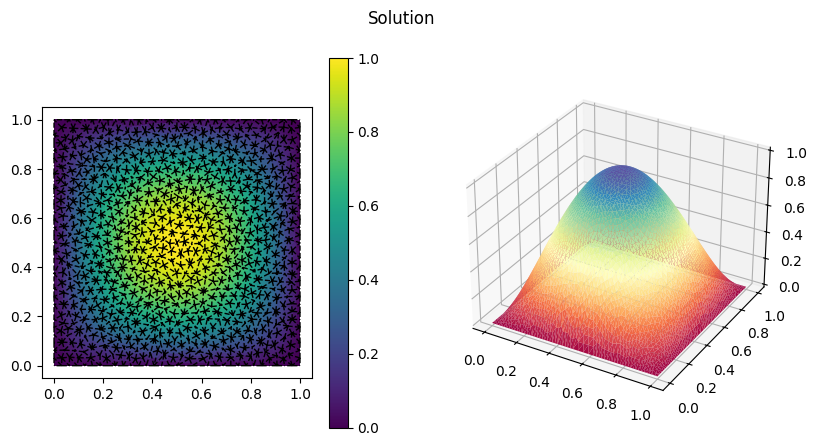

In [9]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)